In [1]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DataCollatorWithPadding, \
                          TrainingArguments, Trainer, pipeline, AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import numpy as np
import requests
from datasets import Dataset
from evaluate import load

In [2]:
# dataset: Toxic Comment Classification Challenge from kaggle
df = pd.read_csv('data/toxic.csv')
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [3]:
LABEL_COLUMNS = df.columns.tolist()[2:]
LABEL_COLUMNS

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

<Axes: >

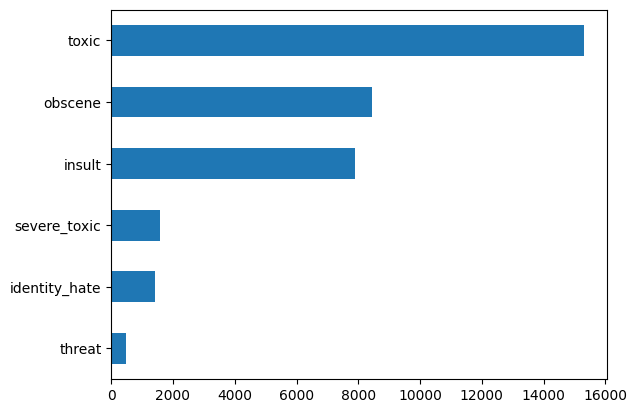

In [8]:
df[LABEL_COLUMNS].sum().sort_values().plot(kind='barh')

<Axes: >

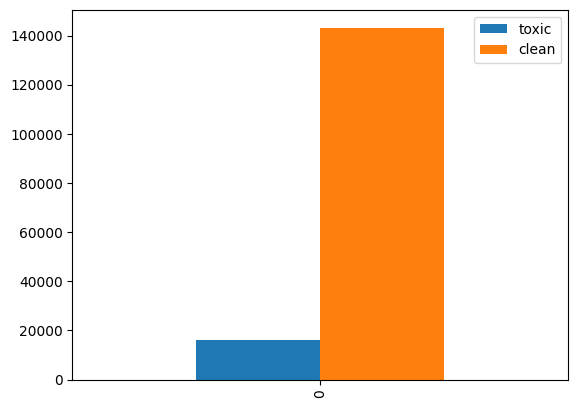

In [9]:
toxic = df[df[LABEL_COLUMNS].sum(axis=1) > 0]
clean = df[df[LABEL_COLUMNS].sum(axis=1) == 0]
pd.DataFrame(
    dict(
      toxic=[len(toxic)],
      clean=[len(clean)]
    )
).plot(kind='bar')

In [15]:
df = pd.concat([
    toxic.sample(10000),
    clean.sample(10000)
], axis=0)
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
66973,b327519cc19200a1,wer do u live \n\nwer do u live marybelle i wa...,1,1,1,0,0,0
99897,16a36ae652a2b7cf,Go fuk your mom you fukin faggot. I'll commit...,1,1,1,0,1,0
142838,fbe950a28c476d7e,NawlinWiki|NawlinWiki]] I have been vilified t...,1,0,0,0,0,0
149084,56d05dc19ba9cd8e,deleting good articles fuck bag,1,0,1,0,0,0
6520,116ff813092530a1,"""\nAnd by nailing Philippa Gregory to the wall...",1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
116224,6d5cb04fbd7a603b,Mr invisible person \n\nhey dude i made my own...,0,0,0,0,0,0
9430,1902f125c73e6370,"Thanks. I have replied. Best, My talk",0,0,0,0,0,0
2697,073fb0b815821818,"""\n\nA poor start, sorry. The author seems to ...",0,0,0,0,0,0
82699,dd30a1715f85bcc2,Museo Bellapart \n\nThank you for providing co...,0,0,0,0,0,0


In [16]:
df['label'] = (df[LABEL_COLUMNS].sum(axis=1) > 0).astype(int)
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
66973,b327519cc19200a1,wer do u live \n\nwer do u live marybelle i wa...,1,1,1,0,0,0,1
99897,16a36ae652a2b7cf,Go fuk your mom you fukin faggot. I'll commit...,1,1,1,0,1,0,1
142838,fbe950a28c476d7e,NawlinWiki|NawlinWiki]] I have been vilified t...,1,0,0,0,0,0,1
149084,56d05dc19ba9cd8e,deleting good articles fuck bag,1,0,1,0,0,0,1
6520,116ff813092530a1,"""\nAnd by nailing Philippa Gregory to the wall...",1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
116224,6d5cb04fbd7a603b,Mr invisible person \n\nhey dude i made my own...,0,0,0,0,0,0,0
9430,1902f125c73e6370,"Thanks. I have replied. Best, My talk",0,0,0,0,0,0,0
2697,073fb0b815821818,"""\n\nA poor start, sorry. The author seems to ...",0,0,0,0,0,0,0
82699,dd30a1715f85bcc2,Museo Bellapart \n\nThank you for providing co...,0,0,0,0,0,0,0


In [17]:
toxic_dataset = Dataset.from_pandas(df)
toxic_dataset = toxic_dataset.train_test_split(test_size=0.2)
toxic_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'label', '__index_level_0__'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'label', '__index_level_0__'],
        num_rows: 4000
    })
})

In [18]:
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
sequence_classification_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=2
)
sequence_classification_model

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [20]:
sequence_classification_model.config.id2label = {0: 'Non-Toxic', 1: 'Toxic'}
sequence_classification_model.config.label2id = {'Non-Toxic': 0, 'Toxic': 1}

In [21]:
def preprocess(examples):
    return bert_tokenizer(examples['comment_text'], truncation=True)

In [22]:
toxic_dataset = toxic_dataset.map(preprocess)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [54]:
toxic_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 4000
    })
})

In [27]:
data_collator = DataCollatorWithPadding(bert_tokenizer)

In [23]:
metric = load('accuracy')
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [24]:
api_key = ''
MODEL_IDENTIFIER = 'f2hard3/distilbert-toxic-classifier'

In [25]:
import torch
import gc

gc.collect()
torch.cuda.empty_cache()

In [28]:
batch_size = 16
epochs = 2

training_args = TrainingArguments(
    output_dir='toxicity/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='toxicity/logs',
    logging_strategy='epoch',
    save_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True
)
trainer = Trainer(
    model=sequence_classification_model,
    tokenizer=bert_tokenizer,
    args=training_args,
    train_dataset=toxic_dataset['train'],
    eval_dataset=toxic_dataset['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [29]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: comment_text, insult, __index_level_0__, threat, identity_hate, severe_toxic, obscene, toxic, id. If comment_text, insult, __index_level_0__, threat, identity_hate, severe_toxic, obscene, toxic, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16


{'eval_loss': 0.7027042508125305,
 'eval_accuracy': 0.499,
 'eval_runtime': 20.8677,
 'eval_samples_per_second': 191.684,
 'eval_steps_per_second': 11.98}

In [30]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: comment_text, insult, __index_level_0__, threat, identity_hate, severe_toxic, obscene, toxic, id. If comment_text, insult, __index_level_0__, threat, identity_hate, severe_toxic, obscene, toxic, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 16000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization s

Epoch,Training Loss,Validation Loss


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: comment_text, insult, __index_level_0__, threat, identity_hate, severe_toxic, obscene, toxic, id. If comment_text, insult, __index_level_0__, threat, identity_hate, severe_toxic, obscene, toxic, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
Saving model checkpoint to toxicity/results/checkpoint-1000
Configuration saved in toxicity/results/checkpoint-1000/config.json
Model weights saved in toxicity/results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in toxicity/results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in toxicity/results/checkpoint-1000/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding

TrainOutput(global_step=2000, training_loss=0.14761947631835937, metrics={'train_runtime': 576.2132, 'train_samples_per_second': 55.535, 'train_steps_per_second': 3.471, 'total_flos': 2839509063496896.0, 'train_loss': 0.14761947631835937, 'epoch': 2.0})

In [31]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: comment_text, insult, __index_level_0__, threat, identity_hate, severe_toxic, obscene, toxic, id. If comment_text, insult, __index_level_0__, threat, identity_hate, severe_toxic, obscene, toxic, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 16


{'eval_loss': 0.1682366281747818,
 'eval_accuracy': 0.934,
 'eval_runtime': 20.3621,
 'eval_samples_per_second': 196.443,
 'eval_steps_per_second': 12.278,
 'epoch': 2.0}

In [32]:
trainer.save_model()

Saving model checkpoint to toxicity/results
Configuration saved in toxicity/results/config.json
Model weights saved in toxicity/results/pytorch_model.bin
tokenizer config file saved in toxicity/results/tokenizer_config.json
Special tokens file saved in toxicity/results/special_tokens_map.json


In [33]:
trainer.model.push_to_hub(MODEL_IDENTIFIER, use_auth_token=api_key)

Configuration saved in /tmp/tmpfn3shl72/config.json
Model weights saved in /tmp/tmpfn3shl72/pytorch_model.bin
Uploading the following files to f2hard3/distilbert-toxic-classifier: config.json,pytorch_model.bin


pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/f2hard3/distilbert-toxic-classifier/commit/1996d9ae09e2e5146e6337d6243462657bae6fd2', commit_message='Upload DistilBertForSequenceClassification', commit_description='', oid='1996d9ae09e2e5146e6337d6243462657bae6fd2', pr_url=None, pr_revision=None, pr_num=None)

In [43]:
trainer.tokenizer.push_to_hub(MODEL_IDENTIFIER, use_auth_token=api_key)

tokenizer config file saved in /tmp/tmppft03t7t/tokenizer_config.json
Special tokens file saved in /tmp/tmppft03t7t/special_tokens_map.json
Uploading the following files to f2hard3/distilbert-toxic-classifier: vocab.txt,tokenizer_config.json,special_tokens_map.json,tokenizer.json


CommitInfo(commit_url='https://huggingface.co/f2hard3/distilbert-toxic-classifier/commit/5e0ff484cdd3a3453a9c9cf096dc407a9bc5c7ee', commit_message='Upload tokenizer', commit_description='', oid='5e0ff484cdd3a3453a9c9cf096dc407a9bc5c7ee', pr_url=None, pr_revision=None, pr_num=None)

In [34]:
auto_tokenizer = AutoTokenizer.from_pretrained(MODEL_IDENTIFIER)
auto_model = AutoModelForSequenceClassification.from_pretrained(MODEL_IDENTIFIER)

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--f2hard3--distilbert-toxic-classifier/snapshots/1996d9ae09e2e5146e6337d6243462657bae6fd2/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--f2hard3--distilbert-toxic-classifier/snapshots/1996d9ae09e2e5146e6337d6243462657bae6fd2/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--f2hard3--distilbert-toxic-classifier/snapshots/1996d9ae09e2e5146e6337d6243462657bae6fd2/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--f2hard3--distilbert-toxic-classifier/snapshots/1996d9ae09e2e5146e6337d6243462657bae6fd2/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--f2hard3--distilbert-toxic-classifier/snapshots/1996d9ae09e2e5146e6337d6243462657bae6fd2/config.json
Model conf

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--f2hard3--distilbert-toxic-classifier/snapshots/1996d9ae09e2e5146e6337d6243462657bae6fd2/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at f2hard3/distilbert-toxic-classifier.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.


In [35]:
toxic_clf = pipeline(
    'text-classification',
    model=auto_model,
    tokenizer=auto_tokenizer,
    use_fast=True,
    return_all_scores=True
)
toxic_clf

/opt/conda/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [36]:
toxic_clf('you are a dumb dumb')

[[{'label': 'Non-Toxic', 'score': 0.001968181924894452},
  {'label': 'Toxic', 'score': 0.9980317950248718}]]

In [37]:
df = pd.concat([
    toxic.sample(500),
    clean.sample(500)
])
df['label'] = (df[LABEL_COLUMNS].sum(axis=1) > 0).astype(int)
new_toxic_dataset = Dataset.from_pandas(df).map(preprocess).train_test_split(test_size=0.2)
new_toxic_dataset

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 800
    })
    test: Dataset({
        features: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 200
    })
})

In [38]:
batch_size = 16
epochs = 2
training_args = TrainingArguments(
    output_dir='toxicity/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='toxicity/logs',
    logging_strategy='epoch',
    save_strategy='epoch',
    evaluation_strategy='epoch',
    load_best_model_at_end=True
)
trainer = Trainer(
    model=auto_model,
    tokenizer=auto_tokenizer,
    args=training_args,
    train_dataset=new_toxic_dataset['train'],
    eval_dataset=new_toxic_dataset['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [39]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: comment_text, insult, __index_level_0__, threat, identity_hate, severe_toxic, obscene, toxic, id. If comment_text, insult, __index_level_0__, threat, identity_hate, severe_toxic, obscene, toxic, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16


{'eval_loss': 0.10332319140434265,
 'eval_accuracy': 0.96,
 'eval_runtime': 1.3373,
 'eval_samples_per_second': 149.554,
 'eval_steps_per_second': 9.721}

In [40]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: comment_text, insult, __index_level_0__, threat, identity_hate, severe_toxic, obscene, toxic, id. If comment_text, insult, __index_level_0__, threat, identity_hate, severe_toxic, obscene, toxic, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 800
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization ste

Epoch,Training Loss,Validation Loss


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: comment_text, insult, __index_level_0__, threat, identity_hate, severe_toxic, obscene, toxic, id. If comment_text, insult, __index_level_0__, threat, identity_hate, severe_toxic, obscene, toxic, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
Saving model checkpoint to toxicity/results/checkpoint-50
Configuration saved in toxicity/results/checkpoint-50/config.json
Model weights saved in toxicity/results/checkpoint-50/pytorch_model.bin
tokenizer config file saved in toxicity/results/checkpoint-50/tokenizer_config.json
Special tokens file saved in toxicity/results/checkpoint-50/special_tokens_map.json
The following columns in the evaluation se

TrainOutput(global_step=100, training_loss=0.10750247716903687, metrics={'train_runtime': 33.2965, 'train_samples_per_second': 48.053, 'train_steps_per_second': 3.003, 'total_flos': 147870873355968.0, 'train_loss': 0.10750247716903687, 'epoch': 2.0})

In [41]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: comment_text, insult, __index_level_0__, threat, identity_hate, severe_toxic, obscene, toxic, id. If comment_text, insult, __index_level_0__, threat, identity_hate, severe_toxic, obscene, toxic, id are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
***** Running Evaluation *****
  Num examples = 200
  Batch size = 16


{'eval_loss': 0.09068845957517624,
 'eval_accuracy': 0.97,
 'eval_runtime': 1.3908,
 'eval_samples_per_second': 143.8,
 'eval_steps_per_second': 9.347,
 'epoch': 2.0}

In [42]:
trainer.save_model()

Saving model checkpoint to toxicity/results
Configuration saved in toxicity/results/config.json
Model weights saved in toxicity/results/pytorch_model.bin
tokenizer config file saved in toxicity/results/tokenizer_config.json
Special tokens file saved in toxicity/results/special_tokens_map.json


In [44]:
trainer.model.push_to_hub(MODEL_IDENTIFIER, use_auth_token=api_key)

Configuration saved in /tmp/tmpamawtnzn/config.json
Model weights saved in /tmp/tmpamawtnzn/pytorch_model.bin
Uploading the following files to f2hard3/distilbert-toxic-classifier: config.json,pytorch_model.bin


Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/f2hard3/distilbert-toxic-classifier/commit/ca3c162f4893e04cd288118929ddfcc041e0fe5f', commit_message='Upload DistilBertForSequenceClassification', commit_description='', oid='ca3c162f4893e04cd288118929ddfcc041e0fe5f', pr_url=None, pr_revision=None, pr_num=None)

In [45]:
trainer.tokenizer.push_to_hub(MODEL_IDENTIFIER, use_auth_token=api_key)

tokenizer config file saved in /tmp/tmpcbw4o5_b/tokenizer_config.json
Special tokens file saved in /tmp/tmpcbw4o5_b/special_tokens_map.json
Uploading the following files to f2hard3/distilbert-toxic-classifier: vocab.txt,tokenizer_config.json,special_tokens_map.json,tokenizer.json


CommitInfo(commit_url='https://huggingface.co/f2hard3/distilbert-toxic-classifier/commit/c819f2c70c81ad9c5869cb4bd77db966ac0ed23c', commit_message='Upload tokenizer', commit_description='', oid='c819f2c70c81ad9c5869cb4bd77db966ac0ed23c', pr_url=None, pr_revision=None, pr_num=None)

In [46]:
toxic_clf = pipeline(
    'text-classification',
    MODEL_IDENTIFIER,
    use_fast=True,
    return_all_scores=True
)
toxic_clf

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--f2hard3--distilbert-toxic-classifier/snapshots/c819f2c70c81ad9c5869cb4bd77db966ac0ed23c/config.json
Model config DistilBertConfig {
  "_name_or_path": "f2hard3/distilbert-toxic-classifier",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Non-Toxic",
    "1": "Toxic"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Non-Toxic": 0,
    "Toxic": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading configuration file config.js

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--f2hard3--distilbert-toxic-classifier/snapshots/c819f2c70c81ad9c5869cb4bd77db966ac0ed23c/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at f2hard3/distilbert-toxic-classifier.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.
loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--f2hard3--distilbert-toxic-classifier/snapshots/c819f2c70c81ad9c5869cb4bd77db966ac0ed23c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--f2hard3--distilbert-toxic-classifier/snapshots/c819f2c70c81ad9c5869cb4bd77db966ac0ed23c/tokenizer.json
loading file added_tokens.json from cac

In [47]:
toxic_clf('you are a dumb dumb')

[[{'label': 'Non-Toxic', 'score': 0.0012168363900855184},
  {'label': 'Toxic', 'score': 0.9987831711769104}]]

In [48]:
API_URL = f'https://api-inference.huggingface.co/models/{MODEL_IDENTIFIER}'
headers = {'Authorization': f'Bearer {api_key}'}
def query(payload):
    response = requests.post(API_URL, headers=headers, json=payload)
    return response.json()

In [51]:
query({
    'inputs': 'you bastard!'
})

[[{'label': 'Toxic', 'score': 0.9988466501235962},
  {'label': 'Non-Toxic', 'score': 0.001153329387307167}]]

In [52]:
toxic_clf = pipeline(
    'text-classification',
    MODEL_IDENTIFIER,
    use_fast=True,
    return_all_scores=True,
    revision='ca3c162f4893e04cd288118929ddfcc041e0fe5f'
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--f2hard3--distilbert-toxic-classifier/snapshots/ca3c162f4893e04cd288118929ddfcc041e0fe5f/config.json
Model config DistilBertConfig {
  "_name_or_path": "f2hard3/distilbert-toxic-classifier",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "Non-Toxic",
    "1": "Toxic"
  },
  "initializer_range": 0.02,
  "label2id": {
    "Non-Toxic": 0,
    "Toxic": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "vocab_size": 30522
}

loading configuration file config.js

In [53]:
toxic_clf('you are a dumb dumb')

[[{'label': 'Non-Toxic', 'score': 0.0012168363900855184},
  {'label': 'Toxic', 'score': 0.9987831711769104}]]